In [1]:
import noise
import pygame
import math
import random
import cv2
from scipy.spatial import Voronoi
import heapq
import matplotlib.pyplot as plt
import time

import numpy as np
import seaborn as sns

pygame 2.3.0 (SDL 2.24.2, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import time

def fib(n):
    if n <= 1:
        return n
    return fib(n - 1) + fib(n - 2)

n = 35
start = time.time()
result = fib(n)
end = time.time()

elapsed = end - start
print(f"Fibonacci({n}) = {result}")
print(f"Elapsed time: {elapsed} seconds")


Fibonacci(35) = 9227465
Elapsed time: 3.597527027130127 seconds


In [3]:
from noise import snoise2

In [4]:
def generate_elevation_volcano_island(seed):
    elevation = [[0] * 100 for _ in range(100)]
    for i in range(100):
        for j in range(100):
            distance_from_center = math.sqrt((i - 50)**2 + (j - 50)**2)
            distance_from_center /= 40.0
            noise_val = noise.snoise3(i/25, j/25, seed, octaves=6, persistence=0.5, lacunarity=2.0)
            noise_val = (noise_val + 1) / 2  # Scale noise value to range (0:1)
            noise_val = noise_val ** 2  # Apply a square function to reduce high values
            elevation[i][j] = int((noise_val + 1 - distance_from_center**2) * 7)
            if elevation[i][j] < 0:
                elevation[i][j] = 0
            elif elevation[i][j] > 10:
                elevation[i][j] = 10
    return elevation


In [5]:
def generate_elevation_island(seed):
    elevation = [[0] * 100 for _ in range(100)]
    for i in range(100):
        for j in range(100):
            distance_from_center = math.sqrt((i - 50)**2 + (j - 50)**2)
            distance_from_center /= 40.0
            noise_val1 = noise.snoise3(i/25, j/25, seed, octaves=6, persistence=0.5, lacunarity=2.0)
            noise_val1 = (noise_val1 + 1) / 2  # Scale noise value to range (0:1)
#             noise_val1 = noise_val1 ** 2  # Apply a square function to reduce high values
            noise_val2 = noise.snoise3(i/50, j/50, seed, octaves=4, persistence=0.5, lacunarity=2.0)
            noise_val2 = (noise_val2 + 1) / 2  # Scale noise value to range (0:1)
#             noise_val2 = noise_val2 ** 3  # Apply a cubic function to increase low values
            elevation[i][j] = int((noise_val1 + noise_val2 - distance_from_center**2) * 7)
            if elevation[i][j] < 0:
                elevation[i][j] = 0
            elif elevation[i][j] > 10:
                elevation[i][j] = 10
    return elevation


In [6]:


def visualize_elevation(elevation):
    pygame.init()
    scale = 10 # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Elevation Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    for i in range(100):
        for j in range(100):
            elevation_value = elevation[i][j]
            gray_value = 255 - elevation_value * 25
            color = (gray_value, gray_value, gray_value)
            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            pygame.draw.rect(screen, color, rect)

            text_surface = font.render(str(elevation_value), True, (255, 255, 255))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()


In [7]:
def visualize_moisture(moisture_matrix):
    pygame.init()
    scale = 10  # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Moisture Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    for i in range(100):
        for j in range(100):
            moisture_value = moisture_matrix[i][j]
            blue_value = int(255 * (moisture_value / 20))
            color = (0, 0, blue_value)
            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            pygame.draw.rect(screen, color, rect)

            text_surface = font.render(str(moisture_value), True, (255, 255, 255))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()


In [8]:
def visualize_map(elevation, lake_mask, river_mask, sea_mask):
    pygame.init()
    scale = 10
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    for i in range(100):
        for j in range(100):
            elevation_value = elevation[i][j]
            if lake_mask[i][j]:
                color = (0, 0, 255)
                elevation_value = -1  # Use a negative value to indicate water
            elif river_mask[i][j]:
                color = (0, 255, 255)
            elif sea_mask[i][j]:
                color = (0, 0, 128)
                elevation_value = -1  # Use a negative value to indicate water
            else:
                gray_value = 255 - elevation_value * 25
                color = (gray_value, gray_value, gray_value)
            rect = pygame.Rect(j * scale, i * scale, scale, scale)
            pygame.draw.rect(screen, color, rect)

            if elevation_value != -1:
                text_surface = font.render(str(elevation_value), True, (255, 255, 255))
                text_rect = text_surface.get_rect(center=rect.center)
                screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()


In [9]:
def generate_elevation_continent(seed=42, num_centers=2, mountains=2):
    corner1 = (25, 25)
    corner2 = (75, 75)
    center_positions = [(random.randint(corner1[0], corner2[0]), random.randint(corner1[1], corner2[1])) for _ in range(num_centers)]
    elevation = [[0] * 100 for _ in range(100)]
    for center in center_positions:
        for i in range(100):
            for j in range(100):
                distance_from_centers = []
                x = center[0]
                y = center[1]
                distance_from_centers.append(math.sqrt((i - x)**2 + (j - y)**2))
                distance_from_centers = [d/25.0 for d in distance_from_centers]  # Scale to range (0:4]
                noise_val1 = noise.snoise3(i/50, j/50, seed, octaves=6, persistence=0.5, lacunarity=2.0)
                noise_val1 = (noise_val1 + 1) / 2  # Scale noise value to range (0:1)
    #             noise_val1 = noise_val1 ** 2  # Apply a square function to reduce high values
                noise_val2 = noise.snoise3(i/25, j/25, seed, octaves=6, persistence=0.5, lacunarity=2.0)
                noise_val2 = (noise_val2 + 1) / 2  # Scale noise value to range (0:1)
    #             noise_val2 = noise_val2 ** 2  # Apply a square function to reduce high values
                noise_val3 = noise.snoise3(i/10, j/10, seed, octaves=4, persistence=0.5, lacunarity=2.0)
                noise_val3 = (noise_val3 + 1) / 2  # Scale noise value to range (0:1)
    #             noise_val3 = noise_val3 ** 3  # Apply a cubic function to increase low values
                temp_elevation = 0
                elevation[i][j] += int((noise_val1 + noise_val2 + noise_val3 - sum(distance_from_centers)**2) * )
                if elevation[i][j] + temp_elevation < 0:
                    elevation[i][j] = 0
                elif elevation[i][j] + temp_elevation > 10:
                    elevation[i][j] = 10
    return elevation


SyntaxError: invalid syntax (1756641843.py, line 24)

In [10]:
def generate_elevation_continent(seed=42, num_centers=2, min_distance=20, mountains=5):
    corner1 = (25, 25)
    corner2 = (75, 75)
    center_positions = []
    while len(center_positions) < num_centers:
        position = (random.randint(corner1[0], corner2[0]), random.randint(corner1[1], corner2[1]))
        if all(math.sqrt((position[0]-x)**2 + (position[1]-y)**2) > min_distance for x, y in center_positions):
            center_positions.append(position)
    elevation = [[0] * 100 for _ in range(100)]
    for center in center_positions:
        for i in range(100):
            for j in range(100):
                distance_from_centers = []
                x = center[0]
                y = center[1]
                distance_from_centers.append(math.sqrt((i - x)**2 + (j - y)**2))
                distance_from_centers = [d/25.0 for d in distance_from_centers]  # Scale to range (0:4]
                noise_val1 = noise.snoise3(i/50, j/50, seed, octaves=6, persistence=0.5, lacunarity=2.0)
                noise_val1 = (noise_val1 + 1) / 2  # Scale noise value to range (0:1)
                noise_val2 = noise.snoise3(i/25, j/25, seed, octaves=6, persistence=0.5, lacunarity=2.0)
                noise_val2 = (noise_val2 + 1) / 2  # Scale noise value to range (0:1)
                noise_val3 = noise.snoise3(i/10, j/10, seed, octaves=4, persistence=0.5, lacunarity=2.0)
                noise_val3 = (noise_val3 + 1) / 2  # Scale noise value to range (0:1)
                elevation[i][j] = max(int((noise_val1 + noise_val2 + noise_val3 - sum(distance_from_centers)**2) * mountains),
                                      elevation[i][j])
                if elevation[i][j] < 0:
                    elevation[i][j] = 0
                elif elevation[i][j] > 10:
                    elevation[i][j] = 10
        
    return elevation

def smooth_mountains(elevation, seed=42, factor=2):
    for i in range(100):
        for j in range(100):
            if elevation[i][j] > 6:
                noise_val4 = noise.snoise3(i/5, j/5, seed, octaves=4, persistence=0.5, lacunarity=5.0)
                noise_val4 = (noise_val4 + 1) / 2  # Scale noise value to range (0:1)
                elevation[i][j] -= int((noise_val4) * factor)

                if elevation[i][j] < 0:
                    elevation[i][j] = 0
                elif elevation[i][j] > 10:
                    elevation[i][j] = 10
    return elevation




In [11]:
import numpy as np

def add_lakes_rivers(elevation_map, height=100, width=100):
    
    water_mask = np.zeros((height, width), dtype=bool)
    
    # Convert the elevation map to a numpy array
    elevation_map = np.array(elevation_map)

    # Get map dimensions
    height, width = elevation_map.shape

    # Create a mask for water tiles
    sea_mask = (elevation_map <= 0)

    # Create a mask for land tiles
    land_mask = (elevation_map > 0)

    # Create a map of distances from water tiles
    dist_map = cv2.distanceTransform(water_mask.astype(np.uint8), cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

    # Normalize the distances to the range [0, 1]
    dist_map /= np.max(dist_map)

    # Create a map of probabilities for adding lakes
    lake_prob_map = np.zeros((height, width))
    lake_prob_map[land_mask] = np.power(dist_map[land_mask], 10)

    # Create a map of probabilities for adding rivers
    river_prob_map = np.zeros((height, width))
    river_prob_map[land_mask] = np.power(dist_map[land_mask], 10)

    # Add lakes
    lake_mask = (np.random.rand(height, width) < lake_prob_map)
    elevation_map[lake_mask] = np.random.randint(-5, 1)

    # Add rivers
    river_mask = (np.random.rand(height, width) < river_prob_map)
    elevation_map[river_mask] -= np.random.randint(1, 5)
    
#     water_mask = np.logical_or(water_mask, lake_mask)
#     water_mask = np.logical_or(water_mask, river_mask)
    sea_mask[elevation_map == 0] = True

    return elevation_map, lake_mask, river_mask, sea_mask


In [12]:
def add_water_features(elevation, seed=42, river_threshold=6, lake_threshold=3, num_rivers=10, num_lakes=5, erosion_factor=0.2):
    water_matrix = [[0] * 100 for _ in range(100)]
    new_elevation = [[elevation[i][j] for j in range(100)] for i in range(100)]
    random.seed(seed)

    def find_lowest_neighbor(i, j):
        lowest = float('inf')
        lowest_pos = (i, j)
        for x in range(-1, 2):
            for y in range(-1, 2):
                new_x = i + x
                new_y = j + y
                if 0 <= new_x < 100 and 0 <= new_y < 100 and not water_matrix[new_x][new_y]:
                    if new_elevation[new_x][new_y] < lowest:
                        lowest = new_elevation[new_x][new_y]
                        lowest_pos = (new_x, new_y)
        return lowest_pos

    # Add rivers
    for _ in range(num_rivers):
        start_i, start_j = random.randint(0, 99), random.randint(0, 99)
        while new_elevation[start_i][start_j] < river_threshold:
            start_i, start_j = random.randint(0, 99), random.randint(0, 99)
        cur_i, cur_j = start_i, start_j

        while new_elevation[cur_i][cur_j] > 0:
            water_matrix[cur_i][cur_j] = 1
            next_i, next_j = find_lowest_neighbor(cur_i, cur_j)
            if (cur_i, cur_j) == (next_i, next_j):  # River reached a local minimum
                break
            cur_i, cur_j = next_i, next_j
            new_elevation[cur_i][cur_j] -= erosion_factor * new_elevation[cur_i][cur_j]

    # Add lakes
    for _ in range(num_lakes):
        lake_i, lake_j = random.randint(0, 99), random.randint(0, 99)
        while new_elevation[lake_i][lake_j] > lake_threshold:
            lake_i, lake_j = random.randint(0, 99), random.randint(0, 99)
        water_matrix[lake_i][lake_j] = 1
        lake_queue = [(lake_i, lake_j)]

        while lake_queue:
            cur_i, cur_j = lake_queue.pop(0)
            for x in range(-1, 2):
                for y in range(-1, 2):
                    new_x = cur_i + x
                    new_y = cur_j + y
                    if 0 <= new_x < 100 and 0 <= new_y < 100 and not water_matrix[new_x][new_y]:
                        if new_elevation[new_x][new_y] <= new_elevation[cur_i][cur_j] and new_elevation[new_x][new_y] > 0:
                            water_matrix[new_x][new_y] = 1
                            lake_queue.append((new_x, new_y))

    for i in range(100):
        for j in range(100):
            if new_elevation[i][j] == 0:
                water_matrix[i][j] = 1

    return np.round(new_elevation).astype(int), water_matrix

In [13]:
def visualize_water(elevation, water_matrix):
    pygame.init()
    scale = 10  # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Water Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    for i in range(100):
        for j in range(100):
            if water_matrix[i][j]:
                elevation_value = elevation[i][j]
                blue_value = 255 - elevation_value * 25
                color = (0, 0, blue_value)
            else:
                elevation_value = elevation[i][j]
                gray_value = 255 - elevation_value * 25
                color = (gray_value, gray_value, gray_value)
            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            pygame.draw.rect(screen, color, rect)

            text_surface = font.render(str(elevation_value), True, (255, 255, 255))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()

In [14]:
def choose_equator_y():
    equator_y = random.choice([random.randint(10, 30), random.randint(70, 90)])
    return equator_y

def temperature_gradient(equator_y, elevation, scale=5):
    temp_matrix = [[0] * 100 for _ in range(100)]

    for i in range(100):
        for j in range(100):
            equator_distance = abs(i - equator_y)

            # Scale the temperature gradient from equator to pole from 1 to 0
            gradient_value = 1 - (equator_distance / (scale * 100))

            # Add Perlin noise for local temperature variation
            noise_value = noise.snoise2(j / 25.0, i / 25.0)
            noise_value = (noise_value + 1) / 2  # Scale noise value to range (0:1)

            # Combine gradient and noise for temperature value
            temperature = gradient_value * 0.9 + noise_value * 0.1
            temperature = int(temperature * 19) + 1

            # Adjust temperature based on elevation (higher = colder)
            temperature -= elevation[i][j] // 2
            temperature = max(1, min(20, temperature))

            temp_matrix[i][j] = temperature

    return temp_matrix


In [15]:
def visualize_temperature(temperature_matrix):
    pygame.init()
    scale = 10  # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Temperature Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    # Color gradient for temperature (from cold to hot)
    temp_colors = [
        (0, 0, 139), (0, 0, 255), (0, 191, 255),
        (135, 206, 250), (173, 216, 230), (176, 224, 230),
        (175, 238, 238), (152, 245, 255), (135, 206, 235),
        (255, 255, 0), (255, 255, 85), (255, 255, 170),
        (255, 165, 0), (255, 193, 37), (255, 223, 75),
        (255, 69, 0), (255, 99, 71), (255, 130, 112),
        (255, 0, 0), (139, 0, 0)
    ]

    for i in range(100):
        for j in range(100):
            temperature_value = temperature_matrix[i][j]
            color = temp_colors[temperature_value - 1]
            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            pygame.draw.rect(screen, color, rect)

            text_surface = font.render(str(temperature_value), True, (0, 0, 0))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()

In [16]:

def quantize_direction(direction):
    angle = np.arctan2(direction[1], direction[0]) * (180 / np.pi)
    quantized_angle = round(angle / 45) * 45
    return (int(np.cos(np.radians(quantized_angle))), int(np.sin(np.radians(quantized_angle))))


In [17]:
def rotate_wind(direction, clockwise):
    rotation_matrix = np.array([[0, -1], [1, 0]]) if clockwise else np.array([[0, 1], [-1, 0]])
    new_direction = np.matmul(rotation_matrix, direction)
    return tuple(new_direction)


In [18]:
# def wind_patterns(temperature_matrix, water_matrix, elevation, equator_y, iterations=10):
#     wind_matrix = np.zeros((100, 100), dtype=[('strength', int), ('direction', int, 2)])
#     north_pole = True if equator_y > 50 else False

#     # Define wind constants
#     WIND_SPAWN_CHANCE = 0.05
#     WIND_SPAWN_CHANCE_ITERATION = 0.05
#     WIND_SPEED = 4
#     WIND_DIFFUSE_FACTOR = 0.005
#     WIND_ROTATE_CHANCE = 0.05
#     WIND_DECAY_FACTOR = 0.001

#     neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]

#     # Initialize wind masses based on polar easterlies, westerlies, and trade winds
#     initialize_wind_masses(wind_matrix, water_matrix, north_pole, equator_y, WIND_SPAWN_CHANCE)

#     wind_matrices = [wind_matrix]

#     # Update wind masses
#     for c in range(iterations):
#         new_wind_matrix = wind_matrix.copy()
#         for i in range(100):
#             if i == equator_y:
#                 continue
#             for j in range(100):
#                 wind = wind_matrix[i][j]
                
                

#                 if wind['strength'] == 0:
#                     wind_matrix[i][j]['direction']= (0,0)
#                     continue

#                 x, y = j, i
#                 dy, dx = wind['direction']
#                 # Move wind
#                 if 0 <= x + dx < 100 and 0 <= y + dy < 100:
#                     if elevation[y+dy][x+dx] < 8:
#                         temp_difference = temperature_matrix[y][x] - temperature_matrix[y+dy][x+dx]
#                         elevation_difference = min(elevation[y][x] - elevation[y+dy][x+dx], 0)
#                         local_wind_speed = WIND_SPEED * (1 + temp_difference/10 + elevation_difference / 5)
#                         new_wind_strength = min(100, max(wind['strength'] * local_wind_speed / 2 - WIND_DECAY_FACTOR * wind['strength'], 0))
#                         new_wind_matrix[i+dy][j+dx]['strength'] = int(new_wind_strength)
#                         new_wind_matrix[i][j]['strength'] -= int(wind['strength'] * local_wind_speed / 2 ) // 2
#                         new_wind_matrix[i][j]['strength'] = max(new_wind_matrix[i][j]['strength'], 0)
#                         new_wind_matrix[i+dy][j+dx]['direction'] = wind['direction']

# #                 # Diffuse wind
# #                 for dx, dy in neighbors:
# #                     if 0 <= x + dx < 100 and 0 <= y + dy < 100:
# #                         new_wind_strength = wind['strength'] * WIND_DIFFUSE_FACTOR
# #                         new_wind_matrix[x+dx][y+dy]['strength'] += new_wind_strength
# #                         new_wind_matrix[x+dx][y+dy]['strength'] = min(max(new_wind_matrix[x+dx][y+dy]['strength'], 0), 100)
# #                         new_wind_matrix[x+dx][y+dy]['direction'] = wind['direction']

#                 # Rotate wind
#                 if random.random() < WIND_ROTATE_CHANCE:
#                     clockwise_rotation = -1 if north_pole else 1
#                     new_wind_matrix[i][j]['direction'] = rotate_wind(wind['direction'], clockwise_rotation > 0)


#         wind_matrix = new_wind_matrix.copy()
#         wind_matrices.append(wind_matrix)

#         # Spawn new wind masses on water tiles
#         initialize_wind_masses(wind_matrix, water_matrix, north_pole, equator_y, WIND_SPAWN_CHANCE_ITERATION, land_wind=False)

#     return wind_matrices

# def initialize_wind_masses(wind_matrix, water_matrix, north_pole, equator_y, spawn_chance, land_wind=True):
#     for i in range(100):
#         for j in range(100):
#             if (land_wind or water_matrix[i][j]) and random.random() < spawn_chance:
#                 if north_pole:
#                     if i < equator_y - 60:  # Polar easterlies
#                         direction = (0, -1)
#                     elif i < equator_y - 20:  # Westerlies
#                         direction = (0, 1)
#                     elif i < equator_y:
#                         direction = (1, -1)# Trade winds
#                     else:  # Trade winds
#                         direction = (-1, -1)
#                 else:
#                     if i > equator_y + 60:  # Polar easterlies
#                         direction = (0, -1)
#                     elif i > equator_y + 20:  # Westerlies
#                         direction = (0, 1)
#                     elif i > equator_y:  # Trade winds
#                         direction = (0, -1)
#                     else:  # Trade winds
#                         direction = (1, -1)
#                 strength = random.randint(30, 100)
#                 wind_matrix[i][j] = (strength, direction)



In [19]:
import numpy as np
import random

def calculate_probabilities(temperature_matrix, water_matrix, elevation, equator_y):
    probabilities = np.zeros((100, 100, 8), dtype=np.float64)
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]

    for i in range(100):
        for j in range(100):
            for k, (dx, dy) in enumerate(neighbors):
                if 0 <= i + dx < 100 and 0 <= j + dy < 100:
                    temp_difference = temperature_matrix[i][j] - temperature_matrix[i+dx][j+dy]
                    elevation_difference = elevation[i][j] - elevation[i+dx][j+dy]
                    if water_matrix[i][j]:
                        probabilities[i][j][k] = max(0, 1 + temp_difference / 10 + elevation_difference / 5)
                    else:
                        probabilities[i][j][k] = max(0, 1 + temp_difference / 10 - elevation_difference / 5)

            probabilities[i][j] /= np.sum(probabilities[i][j]) # normalize probabilities so they sum to 1

    return probabilities

def wind_patterns(probabilities, iterations=10):
    wind_matrix = np.zeros((100, 100), dtype=[('strength', int), ('direction', int, 2)])
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
    
    for c in range(iterations):
        for i in range(100):
            for j in range(100):
                direction = np.random.choice(8, p=probabilities[i][j]) # choose direction based on probabilities
                wind_matrix[i][j]['direction'] = neighbors[direction]
                wind_matrix[i][j]['strength'] = random.randint(30, 100)

    return wind_matrix


In [20]:
def visualize_wind(wind_matrix, sleep=1):
    pygame.init()
    scale = 10  # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Wind Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    arrow_symbols = {
        (0, -1): "←",
        (-1, -1): "↖",
        (-1, 0): "↑",
        (-1, 1): "↗",
        (0, 1): "→",
        (1, 1): "↘",
        (1, 0): "↓",
        (1, -1): "↙",
        (0, 0): '.'
    }

    for i in range(100):
        for j in range(100):
            wind_strength = int(wind_matrix[i][j][0])
            wind_direction = tuple(wind_matrix[i][j][1])

            # Color based on wind strength (light blue to dark blue)
            color = (int(255 - wind_strength*2), int(255 - wind_strength*2), 255)
#             color = (int(255), int(255), 255)

            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            try:
                pygame.draw.rect(screen, color, rect)
            except:
                print(wind_strength)

            symbol = arrow_symbols[wind_direction]
            text_surface = font.render(symbol, True, (0, 0, 0))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

#     running = True
#     while running:
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 running = False

    time.sleep(sleep)

    pygame.quit()


In [22]:
def wind_rose(wind_matrices):
    wind_rose_matrix = np.zeros((100, 100, 8), dtype=int)  # 8 directions: up-left, up, up-right, right, down-right, down, down-left, left
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]

    for wind_matrix in wind_matrices:
        for i in range(100):
            for j in range(100):
                wind = wind_matrix[i][j]
                if wind['strength'] == 0:
                    continue
                
                for idx, (dx, dy) in enumerate(directions):
                    if tuple(wind['direction']) == (dx, dy):
                        wind_rose_matrix[i][j][idx] += wind['strength']

    return wind_rose_matrix


In [20]:
# def generate_moisture(elevation_matrix, wind_rose_matrix, water_mask, temperature_matrix, wind_scale=0.5, 
#                       elevation_scale = 0.1, iterations=100):
#     moisture_matrix = np.zeros((100, 100), dtype=float)
    
#     # Initialize moisture based on water_mask
#     for i in range(100):
#         for j in range(100):
#             if water_mask[i][j]:
#                 moisture_matrix[i][j] = 1.
                
#     neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
    
#     for _ in range(iterations):
#         new_moisture_matrix = moisture_matrix.copy()
        
#         for i in range(100):
#             for j in range(100):
#                 if water_mask[i][j]:
#                     continue
                    
#                 x, y = i, j
                
#                 for idx, (nx, ny) in enumerate(neighbors):
#                 # Wind
#                     if 0 <= x + nx < 100 and 0 <= y + ny < 100:
#                         wind_strength = wind_rose_matrix[x+nx][y+ny][idx] 
# #                         transfer_amount = max(0, wind_strength)
#                         transfer_amount = moisture_matrix[x+nx][y+ny] * (wind_strength/20) * wind_scale
#                         new_moisture_matrix[x][y] += transfer_amount
# #                         print(transfer_amount)
#                         if not water_mask[x+nx][y+ny]:
#                             new_moisture_matrix[x+nx][y+ny] -= transfer_amount 
#                             new_moisture_matrix[x+nx][y+ny] = max(min(new_moisture_matrix[x+nx][y+ny], 1), 0)
#                 # Elevation
#                         elevation_strength = max(0, int((1 + elevation_matrix[x+nx][y+ny] - elevation_matrix[x][y]))/10)
#                         transfer_amount = moisture_matrix[x+nx][y+ny] * elevation_strength * elevation_scale
#                         new_moisture_matrix[x][y] += transfer_amount
#                         if not water_mask[x+nx][y+ny]:
#                             new_moisture_matrix[x+nx][y+ny] -= transfer_amount
#                             new_moisture_matrix[x+nx][y+ny] = max(min(new_moisture_matrix[x+nx][y+ny], 1), 0)
                        

#                 new_moisture_matrix[x][y] = min(max(new_moisture_matrix[x][y], 0), 1)
                        
#         moisture_matrix = new_moisture_matrix.copy()
        
#     return np.round(moisture_matrix*20).astype(int)


In [23]:
def calculate_moisture_probabilities(elevation, wind_matrix, water_mask, wind_scale=0.5, elevation_scale=0.1):
    probabilities = np.zeros((100, 100, 8), dtype=np.float64)
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]

    for i in range(100):
        for j in range(100):
            for k, (dx, dy) in enumerate(neighbors):
                if 0 <= i + dx < 100 and 0 <= j + dy < 100:
                    wind_strength = wind_matrix[i+dx][j+dy]['strength']
                    elevation_difference = max(0, int((1 + elevation[i+dx][j+dy] - elevation[i][j])) / 10)
                    probabilities[i][j][k] = max(0, wind_strength * wind_scale / 20 + elevation_difference * elevation_scale)

            probabilities[i][j] /= np.sum(probabilities[i][j]) # normalize probabilities so they sum to 1

    return probabilities

def generate_moisture(probabilities, water_mask, iterations=100):
    moisture_matrix = np.zeros((100, 100), dtype=float)
    neighbors = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]
    
    # Initialize moisture based on water_mask
    for i in range(100):
        for j in range(100):
            if water_mask[i][j]:
                moisture_matrix[i][j] = 1.
    
    for _ in range(iterations):
        for i in range(100):
            for j in range(100):
                if not water_mask[i][j]:
                    direction = np.random.choice(8, p=probabilities[i][j]) # choose direction based on probabilities
                    moisture_matrix[i][j] = moisture_matrix[i + neighbors[direction][0]][j + neighbors[direction][1]]
        
        moisture_matrix = np.clip(moisture_matrix, 0, 1)

    return np.round(moisture_matrix*20).astype(int)




In [24]:
import scipy.ndimage as ndi
def generate_moisture_simple(elevation_matrix, water_mask, temperature_matrix, rng_seed=0):
    np.random.seed(rng_seed) # for consistent results

    distance_to_water = ndi.distance_transform_edt(~water_mask) # calculate the euclidean distance to the nearest water cell for each cell
    normalized_distance_to_water = distance_to_water / np.max(distance_to_water) # normalize to [0,1]
    normalized_temperature = (temperature_matrix - np.min(temperature_matrix)) / (np.max(temperature_matrix) - np.min(temperature_matrix)) # normalize to [0,1]
    
    # The moisture is a combination of the distance to water, temperature, and some random factor
    # The closer to water, the more moist (lower distance is higher moisture)
    # The cooler the temperature, the more moist (lower temperature is higher moisture)
    moisture_matrix = (1 - normalized_distance_to_water) * 0.5 + (1 - normalized_temperature) * 0.5 + np.random.rand(100,100) * 0.1
    moisture_matrix = np.clip(moisture_matrix, 0, 1) # ensure values are within [0,1]

    return np.round(moisture_matrix*20).astype(int)

In [25]:
def draw_visualization(current_visualization):
    if current_visualization == 'water':
        visualize_water(water_matrix, new_elevation)
    elif current_visualization == 'temperature':
        visualize_temperature(temperature_matrix)

In [26]:
def world_map():
    pygame.init()
    scale = 10  # Increase this value to make the window larger
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('World Visualization')

    current_visualization = 'water'

    draw_visualization(current_visualization)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    current_visualization = 'water'
                    draw_visualization(current_visualization)
                elif event.key == pygame.K_RIGHT:
                    current_visualization = 'temperature'
                    draw_visualization(current_visualization)

    pygame.quit()

In [62]:
def generate_biomes(temperature_matrix, moisture_matrix, elevation_matrix, wind_rose_matrix, water_matrix):
    biome_matrix = np.empty((100, 100), dtype=object)
    
    for i in range(100):
        for j in range(100):
            temperature = temperature_matrix[i][j]
            moisture = moisture_matrix[i][j]
            elevation = elevation_matrix[i][j]
            water = water_matrix[i][j]
            
            best_biome = None
            best_biome_score = float('inf')
            
            # If the current cell is water, assign the water biome
            if water:
                if temperature == 1:
                    biome_matrix[i][j] = 'Glacier'
                else:
                    biome_matrix[i][j] = 'Water'
                continue
                
            for biome, criteria in biome_definitions.items():
                temp_range = criteria['temperature_range']
                moisture_range = criteria['moisture_range']
                elevation_range = criteria['elevation_range']
                
                temp_score = abs(temperature - (temp_range[0] + temp_range[1]) / 2)
                moisture_score = abs(moisture - (moisture_range[0] + moisture_range[1]) / 2)
                elevation_score = abs(elevation - (elevation_range[0] + elevation_range[1]) / 2)
                
                total_score = temp_score + moisture_score + elevation_score
                if total_score < best_biome_score:
                    best_biome_score = total_score
                    best_biome = biome
            
            biome_matrix[i][j] = best_biome
            
    return biome_matrix


In [28]:
import pygame
import time

def visualize_biomes(biome_matrix, elevation_matrix, scale=10):
    pygame.init()
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Biome Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    for i in range(100):
        for j in range(100):
            biome = biome_matrix[i][j]
            elevation = elevation_matrix[i][j]

            color = biome_colors[biome]

            rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
            pygame.draw.rect(screen, color, rect)

            text_surface = font.render(str(elevation), True, (0, 0, 0))
            text_rect = text_surface.get_rect(center=rect.center)
            screen.blit(text_surface, text_rect)

    pygame.display.update()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()


In [29]:
elevation = generate_elevation_continent(random.randint(1, 10000), random.randint(3, 6), 
                                         mountains=5)
smoothed_elevation = smooth_mountains(elevation)

In [30]:
new_elevation, water_matrix = add_water_features(smoothed_elevation)

In [31]:
visualize_elevation(new_elevation)

In [32]:
visualize_water(new_elevation, water_matrix)

In [33]:
# equator_y = choose_equator_y()
equator_y = random.choice([25, 75])
equator_y

75

In [34]:
temperature_matrix = temperature_gradient(equator_y, new_elevation, scale=.7)

In [35]:
visualize_temperature(temperature_matrix)

In [38]:
# Define your matrices: temperature_matrix, water_matrix, and elevation
probabilities = calculate_probabilities(temperature_matrix, water_matrix, new_elevation, equator_y=50)
wind_matrix = wind_patterns(probabilities, iterations=10)

In [44]:
visualize_wind(wind_matrix)

In [45]:
if isinstance(water_matrix, list):
    water_mask = np.array(water_matrix)

In [46]:
moisture_matrix = generate_moisture_simple(new_elevation, water_mask, temperature_matrix, rng_seed=0)

In [82]:
from scipy.signal import convolve2d

def smooth_matrix(matrix, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), dtype=float) / (kernel_size * kernel_size)
    
    smoothed_matrix = matrix.copy()
    
    for _ in range(iterations):
        smoothed_matrix = convolve2d(smoothed_matrix, kernel, mode='same', boundary='fill', fillvalue=0)
        
    return np.round(smoothed_matrix).astype(int)

In [47]:
visualize_moisture(moisture_matrix)

In [93]:
moisture_smoothed = smooth_matrix(moisture_matrix)

In [48]:
moisture_smoothed = moisture_matrix

In [110]:
visualize_moisture(moisture_smoothed)

In [49]:
visualize_water(new_elevation, water_matrix)

In [50]:
visualize_temperature(temperature_matrix)

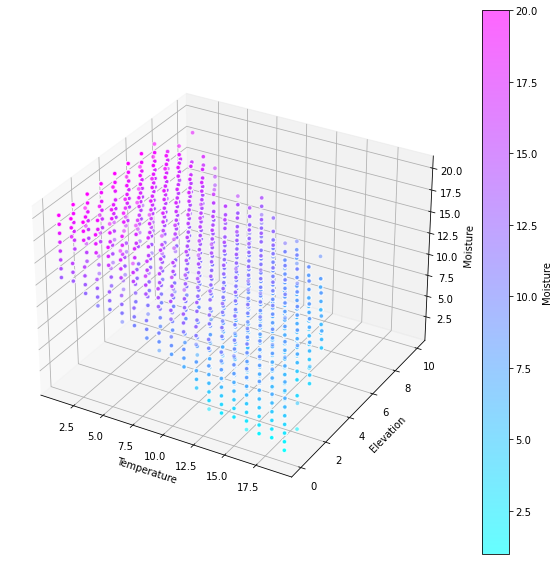

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_scatter(temp_matrix, elevation_matrix, moisture_matrix):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # flatten the matrices and convert them to 1D arrays
    temp = temp_matrix.flatten()
    elevation = elevation_matrix.flatten()
    moisture = moisture_matrix.flatten()

    scatter = ax.scatter(temp, elevation, moisture, c=moisture, alpha=0.6, edgecolors='w', cmap='cool')

    ax.set_xlabel('Temperature')
    ax.set_ylabel('Elevation')
    ax.set_zlabel('Moisture')

    plt.colorbar(scatter, label='Moisture')
    plt.show()

# Use the function
plot_3D_scatter(np.array(temperature_matrix), new_elevation, moisture_matrix)


In [52]:
elevation = np.array(new_elevation)

In [53]:
temperature = np.array(temperature_matrix)

In [54]:
moisture_smoothed

array([[20, 20, 20, ..., 13, 15, 13],
       [20, 20, 20, ..., 14, 13, 14],
       [20, 20, 20, ..., 15, 15, 15],
       ...,
       [ 8,  6,  7, ...,  4,  4,  3],
       [ 7,  8,  8, ...,  5,  5,  4],
       [ 8,  7,  7, ...,  5,  3,  5]])

In [55]:
from collections import defaultdict

# Initialize a 3D grid to count the number of tiles in each cell
grid_counts = defaultdict(int)

# Loop over all tiles
for temperature, moisture, elevation in zip(temperature.flatten(), moisture_smoothed.flatten(), elevation.flatten()):
    # Compute the cell coordinates in the 3D grid
    t_cell = int(temperature // 5)
    m_cell = int(moisture // 7)
    e_cell = int(elevation // 4)
    
    # Increment the count for this cell
    grid_counts[(t_cell, m_cell, e_cell)] += 1

# Print the counts
for (t_cell, m_cell, e_cell), count in grid_counts.items():
    print(f"Temperature: {t_cell*5}-{(t_cell+1)*5}, Moisture: {m_cell*7}-{(m_cell+1)*7}, Elevation: {e_cell*4}-{(e_cell+1)*4}, Count: {count}")


Temperature: 0-5, Moisture: 14-21, Elevation: 0-4, Count: 945
Temperature: 0-5, Moisture: 14-21, Elevation: 4-8, Count: 1384
Temperature: 0-5, Moisture: 7-14, Elevation: 0-4, Count: 111
Temperature: 5-10, Moisture: 7-14, Elevation: 0-4, Count: 437
Temperature: 5-10, Moisture: 14-21, Elevation: 0-4, Count: 278
Temperature: 0-5, Moisture: 14-21, Elevation: 8-12, Count: 125
Temperature: 0-5, Moisture: 7-14, Elevation: 4-8, Count: 40
Temperature: 5-10, Moisture: 14-21, Elevation: 4-8, Count: 491
Temperature: 5-10, Moisture: 7-14, Elevation: 4-8, Count: 826
Temperature: 0-5, Moisture: 7-14, Elevation: 8-12, Count: 2
Temperature: 5-10, Moisture: 14-21, Elevation: 8-12, Count: 10
Temperature: 10-15, Moisture: 7-14, Elevation: 0-4, Count: 799
Temperature: 10-15, Moisture: 14-21, Elevation: 0-4, Count: 8
Temperature: 5-10, Moisture: 7-14, Elevation: 8-12, Count: 40
Temperature: 10-15, Moisture: 7-14, Elevation: 4-8, Count: 1676
Temperature: 10-15, Moisture: 0-7, Elevation: 0-4, Count: 475
Tempe

In [70]:
biome_definitions = {
    'Tundra': {'temperature_range': (0, 5), 'moisture_range': (14, 21), 'elevation_range': (0, 4)},
    'Taiga': {'temperature_range': (0, 5), 'moisture_range': (7, 14), 'elevation_range': (0, 4)},
    'Snow Forest': {'temperature_range': (0, 5), 'moisture_range': (14, 21), 'elevation_range': (4, 8)},
    'Cold Steppe': {'temperature_range': (0, 5), 'moisture_range': (7, 14), 'elevation_range': (4, 8)},
    'Snow Mountain': {'temperature_range': (0, 5), 'moisture_range': (7, 14), 'elevation_range': (8, 12)},
    'Glacier': {'temperature_range': (0, 5), 'moisture_range': (14, 21), 'elevation_range': (8, 12)},
    'Temperate Rainforest': {'temperature_range': (5, 10), 'moisture_range': (14, 21), 'elevation_range': (0, 4)},
    'Temperate Forest': {'temperature_range': (5, 10), 'moisture_range': (7, 14), 'elevation_range': (0, 4)},
    'Temperate Hill': {'temperature_range': (5, 10), 'moisture_range': (7, 14), 'elevation_range': (4, 8)},
    'Mountain Forest': {'temperature_range': (5, 10), 'moisture_range': (7, 14), 'elevation_range': (8, 12)},
    'Mountain Rainforest': {'temperature_range': (5, 10), 'moisture_range': (14, 21), 'elevation_range': (4, 8)},
    'High Mountain Rainforest': {'temperature_range': (5, 10), 'moisture_range': (14, 21), 'elevation_range': (8, 12)},
    'Desert': {'temperature_range': (15, 20), 'moisture_range': (0, 7), 'elevation_range': (0, 4)},
    'Hot Desert': {'temperature_range': (15, 20), 'moisture_range': (0, 7), 'elevation_range': (4, 8)},
    'Savanna': {'temperature_range': (10, 15), 'moisture_range': (0, 7), 'elevation_range': (0, 4)},
    'Temperate Savanna': {'temperature_range': (10, 15), 'moisture_range': (7, 14), 'elevation_range': (0, 4)},
    'Mountain Savanna': {'temperature_range': (10, 15), 'moisture_range': (7, 14), 'elevation_range': (4, 8)},
    'High Mountain Savanna': {'temperature_range': (10, 15), 'moisture_range': (7, 14), 'elevation_range': (8, 12)},
    'Jungle': {'temperature_range': (10, 15), 'moisture_range': (14, 21), 'elevation_range': (0, 4)},
    'Hot Jungle': {'temperature_range': (15, 20), 'moisture_range': (7, 14), 'elevation_range': (0, 4)},
    'Mountain Jungle': {'temperature_range': (15, 20), 'moisture_range': (7, 14), 'elevation_range': (4, 8)}
}



biome_colors = {
    'Tundra': (166, 235, 227),
    'Taiga': (79, 137, 102),
    'Snow Forest': (79, 137, 200),
    'Cold Steppe': (180, 207, 234),
    'Snow Mountain': (150, 180, 180),
    'Glacier': (240, 254, 255),
    'Temperate Rainforest': (13, 94, 53),
    'Temperate Forest': (19, 166, 12),
    'Temperate Hill': (19, 166, 50),
    'Mountain Forest': (50, 100, 50),
    'Mountain Rainforest': (13, 94, 53),
    'High Mountain Rainforest': (10, 84, 90),
    'Desert': (255, 241, 46),
    'Hot Desert': (255, 200, 46),
    'Savanna': (145, 161, 92),
    'Temperate Savanna': (145, 161, 120),
    'Mountain Savanna': (145, 161, 150),
    'High Mountain Savanna': (145, 161, 180),
    'Jungle': (41, 122, 37),
    'Hot Jungle': (20, 61, 18),
    'Mountain Jungle': (20, 61, 50),
    'Water': (0,0,139),
    None: (0, 0, 0),
}


In [72]:
biome_definitions.keys()

dict_keys(['Tundra', 'Taiga', 'Snow Forest', 'Cold Steppe', 'Snow Mountain', 'Glacier', 'Temperate Rainforest', 'Temperate Forest', 'Temperate Hill', 'Mountain Forest', 'Mountain Rainforest', 'High Mountain Rainforest', 'Desert', 'Hot Desert', 'Savanna', 'Temperate Savanna', 'Mountain Savanna', 'High Mountain Savanna', 'Jungle', 'Hot Jungle', 'Mountain Jungle'])

In [64]:
biomes = generate_biomes(temperature_matrix, moisture_smoothed, new_elevation, wind_matrix, water_matrix)

In [71]:
visualize_biomes(biomes, new_elevation)

In [73]:
biomes

array([['Glacier', 'Glacier', 'Glacier', ..., 'Glacier', 'Glacier',
        'Glacier'],
       ['Glacier', 'Glacier', 'Glacier', ..., 'Glacier', 'Glacier',
        'Glacier'],
       ['Glacier', 'Glacier', 'Glacier', ..., 'Glacier', 'Glacier',
        'Glacier'],
       ...,
       ['Water', 'Water', 'Water', ..., 'Water', 'Water', 'Water'],
       ['Water', 'Water', 'Water', ..., 'Water', 'Water', 'Water'],
       ['Water', 'Water', 'Water', ..., 'Water', 'Water', 'Water']],
      dtype=object)

# Animals

In [114]:
biome_species = {
    'Tundra': ['Arctic fox', 'Polar bear', 'Snowy owl', 'Reindeer', 'Arctic hare', 'Muskox', 'Lemming', 'Wolverine', 'Snow bunting', 'Ptarmigan'],
    'Taiga': ['Siberian tiger', 'Wolverine', 'Red fox', 'Snowshoe hare', 'Lynx', 'Elk', 'Ermine', 'Beaver', 'Gray wolf', 'Black bear'],
    'Snow Forest': ['Snowy owl', 'Arctic hare', 'Reindeer', 'Moose', 'Red fox', 'Bison', 'Beaver', 'Ermine', 'Gray wolf', 'White-tailed deer'],
    'Cold Steppe': ['Pronghorn', 'Bison', 'Badger', 'Arctic hare', 'Mule deer', 'Coyote', 'Black-footed ferret', 'Jackrabbit', 'Gray wolf', 'Snowy owl'],
    'Snow Mountain': ['Snow leopard', 'Yak', 'Himalayan tahr', 'Alpine chough', 'Wolverine', 'Argali', 'Bharal', 'Ibex', 'Markhor', 'Himalayan marmot'],
    'Glacier': ['Penguin', 'Seal', 'Polar bear', 'Walrus', 'Arctic fox', 'Beluga whale', 'Arctic hare', 'Snow petrel', 'Killer whale', 'Krill'],
    'Temperate Rainforest': ['Black bear', 'Cougar', 'Elk', 'Bald eagle', 'Salamander', 'Owl', 'Raccoon', 'Raven', 'Fisher', 'Bobcat'],
    'Temperate Forest': ['Deer', 'Fox', 'Badger', 'Squirrel', 'Hedgehog', 'Raccoon', 'Opossum', 'Skunk', 'Woodchuck', 'Wild boar'],
    'Temperate Hill': ['Mountain goat', 'Coyote', 'Puma', 'Pronghorn', 'Elk', 'Bighorn sheep', 'Marmot', 'Jackrabbit', 'Ground squirrel', 'Badger'],
    'Mountain Forest': ['Black bear', 'Elk', 'Mule deer', 'Mountain lion', 'Bobcat', 'Coyote', 'Gray fox', 'Porcupine', 'Raccoon', 'Mountain goat'],
    'Mountain Rainforest': ['Mountain gorilla', 'Chimpanzee', 'Okapi', 'African golden cat', 'Giant forest hog', 'Forest elephant', 'Bonobo', 'Pangolin', 'Mandrill', 'African civet'],
    'High Mountain Rainforest': ['Andean bear', 'Mountain tapir', 'Andean cock-of-the-rock', 'Spectacled bear', 'Puma', 'Andean condor', 'Guanaco', 'Vicuna', 'Chinchilla', 'Mountain vizcacha'],
    'Desert': ['Camel', 'Fennec fox', 'Dromedary', 'Jerboa', 'Desert hedgehog', 'Caracal', 'Gazelle', 'Scorpion', 'Oryx', 'Armadillo'],
    'Hot Desert': ['Camel', 'Dromedary', 'Fennec fox', 'Horned viper', 'Jerboa', 'Spiny-tailed lizard', 'Desert monitor', 'Scarab beetle', 'Deathstalker', 'Ostrich'],
    'Savanna': ['Lion', 'Elephant', 'Giraffe', 'Zebra', 'Hippopotamus', 'Cheetah', 'Hyena', 'Wildebeest', 'African buffalo', 'Meerkat'],
    'Temperate Savanna': ['Kangaroo', 'Emu', 'Wombat', 'Dingo', 'Koala', 'Platypus', 'Echidna', 'Cassowary', 'Bandicoot', 'Wallaby'],
    'Mountain Savanna': ['Mountain zebra', 'Baboon', 'Hyena', 'Leopard', 'Meerkat', 'Aardvark', 'Ostrich', 'Warthog', 'Impala', 'Cheetah'],
    'High Mountain Savanna': ['Mountain gorilla', 'Leopard', 'African buffalo', 'Hyena', 'Warthog', 'Baboon', 'Aardvark', 'African elephant', 'Cheetah', 'Gazelle'],
    'Jungle': ['Jaguar', 'Spider monkey', 'Macaw', 'Sloth', 'Iguana', 'Anaconda', 'Capybara', 'Tapir', 'Toucan', 'Caiman'],
    'Hot Jungle': ['Tiger', 'Asian elephant', 'Orangutan', 'Pangolin', 'Clouded leopard', 'Sun bear', 'Hornbill', 'Binturong', 'Proboscis monkey', 'Komodo dragon'],
    'Mountain Jungle': ['Andean condor', 'Spectacled bear', 'Andean cock-of-the-rock', 'Mountain tapir', 'Puma', 'Andean bear', 'Jaguar', 'Howler monkey', 'Sloth', 'Macaw']
}


In [76]:
biome_matrix = biomes

In [108]:
[(x* 10, y*10) for x, y in population_capacities]

[(10000000, 20000000),
 (5000000, 10000000),
 (2000000, 5000000),
 (1000000, 2000000),
 (500000, 1000000),
 (100000, 500000),
 (10000, 100000)]

In [115]:
import numpy as np
import random

# Define size tiers
size_tiers = ['tiny', 'small', 'medium-sized', 'big', 'enormous', 'gigantic', 'colossal']
new_species_probabilities = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01]  # Probabilities for creating a new species
population_capacities = [(1000000, 2000000), (500000, 1000000), (200000, 500000), (100000, 200000), (50000, 100000), (10000, 50000), (1000, 10000)]  # Define population capacities for each size tier
population_capacities = [(x* 10, y*10) for x, y in population_capacities]

# Initialize world fauna
world_fauna = {}
species_pool = {}

# Create species id counter
species_id = 0

for i in range(100):  # Loop over tiles
    for j in range(100):
        tile_species = {}
        biome = biome_matrix[i][j]
        if biome in biome_species:  # Check if biome is in the dictionary
            for size in size_tiers:  # Loop over size tiers
                existing_species = [sp for sp in species_pool if species_pool[sp]['size'] == size and species_pool[sp]['remaining_population'] > 0 and biome in species_pool[sp]['biomes']]
                
                if existing_species:
                    sp = random.choice(existing_species)
                    population = min(random.randint(1, 5000), species_pool[sp]['remaining_population'])  # Population is random but can't exceed the remaining population of the species
                    species_pool[sp]['remaining_population'] -= population
                    
                elif random.random() < new_species_probabilities[size_tiers.index(size)]:  # Create a new species with a certain probability
                    base_species = random.choice(biome_species[biome])
                    magic = random.choice(magical_properties)  # Choose a magical property
                    max_population = random.randint(*population_capacities[size_tiers.index(size)])  # Population size depends on the size tier
                    population = random.randint(1, max_population)
                    sp = f"{base_species}_{species_id}"
                    species_id += 1  # Increase the species id counter for each new species
                    species_pool[sp] = {'base_species': base_species, 'size': size, 'magic': magic, 'max_population': max_population, 'remaining_population': max_population - population, 'biomes': [biome]}
                else:
                    continue  # If no existing species are found and we decide not to create a new one, move to the next tile
                
                tile_species[sp] = {'size': size, 'magic': species_pool[sp]['magic'], 'population': population}
        world_fauna[(i, j)] = tile_species


In [116]:
len(species_pool)

328

In [122]:
world_fauna

{(0,
  0): {'Killer whale_0': {'size': 'tiny',
   'magic': 'mind-reading',
   'population': 4332425}, 'Walrus_1': {'size': 'small',
   'magic': 'shapeshifting',
   'population': 3776189}},
 (0,
  1): {'Killer whale_0': {'size': 'tiny',
   'magic': 'mind-reading',
   'population': 1569}, 'Walrus_1': {'size': 'small',
   'magic': 'shapeshifting',
   'population': 3713}},
 (0,
  2): {'Killer whale_0': {'size': 'tiny',
   'magic': 'mind-reading',
   'population': 341}, 'Walrus_1': {'size': 'small',
   'magic': 'shapeshifting',
   'population': 2043}, 'Snow petrel_2': {'size': 'big',
   'magic': 'teleporting',
   'population': 590323}},
 (0,
  3): {'Killer whale_0': {'size': 'tiny',
   'magic': 'mind-reading',
   'population': 3052}, 'Walrus_1': {'size': 'small',
   'magic': 'shapeshifting',
   'population': 4204}, 'Snow petrel_2': {'size': 'big',
   'magic': 'teleporting',
   'population': 3327}, 'Walrus_3': {'size': 'enormous',
   'magic': 'mind-reading',
   'population': 555320}},
 (0,
 

# Humans

In [127]:
biome_pop_capacity = {
    'Glacier': 50,
    'Tundra': 2000,
    'Taiga': 5000,
    'Snow Forest': 10000,
    'Cold Steppe': 15000,
    'Snow Mountain': 3000,
    'Temperate Rainforest': 30000,
    'Temperate Forest': 40000,
    'Temperate Hill': 100000,
    'Mountain Forest': 25000,
    'Mountain Rainforest': 25000,
    'High Mountain Rainforest': 10000,
    'Desert': 100,
    'Hot Desert': 0,
    'Savanna': 20000,
    'Temperate Savanna': 35000,
    'Mountain Savanna': 15000,
    'High Mountain Savanna': 10000,
    'Jungle': 15000,
    'Hot Jungle': 10000,
    'Mountain Jungle': 10000,
    'Water': 0
}


In [128]:
tile_pop_capacity = np.zeros((100, 100), dtype=int)
for i in range(100):
    for j in range(100):
        tile_pop_capacity[i][j] = biome_pop_capacity[biome_matrix[i][j]]


In [129]:
pop_center_tiles = []
potential_pop_center_tiles = sorted(
    [(i, j) for i in range(100) for j in range(100)],
    key=lambda t: tile_pop_capacity[t[0]][t[1]],
    reverse=True)

while potential_pop_center_tiles:
    i, j = potential_pop_center_tiles.pop(0)
    pop_center_tiles.append((i, j))
    potential_pop_center_tiles = [
        t for t in potential_pop_center_tiles
        if abs(t[0]-i) > 10 or abs(t[1]-j) > 10]


In [130]:
tile_pop = np.zeros((100, 100), dtype=int)
for i, j in pop_center_tiles:
    for di in range(-10, 11):
        for dj in range(-10, 11):
            if (0 <= i+di < 100 and 0 <= j+dj < 100):
                distance = abs(di) + abs(dj)
                tile_pop[i+di][j+dj] = int(tile_pop_capacity[i+di][j+dj] / (distance + 1))


In [133]:
pop_values = np.clip(tile_pop / 10000, 0, 9)  # Adjust to 0-9 range for display
pop_values = pop_values.astype(int)
pop_strings = pop_values.astype(str)


In [136]:
# Remove the None key from the dictionary
if None in biome_colors:
    del biome_colors[None]

In [ ]:
2+2


In [ ]:
import tkinter as tk

# Initialize the window
root = tk.Tk()
root.state('withdrawn')
root.title("World Map")

# Create a Text widget
text = tk.Text(root, font=("Courier", 10))
text.pack()

# Map the colors to biome
color_map = {biome: f"color{index}" for index, biome in enumerate(biome_colors.keys())}

# Configure the tags for the Text widget
for biome, tag in color_map.items():
    color = biome_colors[biome]
    if color is not None:
        color_hex = '#%02x%02x%02x' % color
        text.tag_config(tag, background=color_hex)

# Configure the tag for population center
text.tag_config('pop_center', foreground="black")

# Insert map data
for i in range(100):
    for j in range(100):
        # Get the biome and population data for the current tile
        biome = biome_matrix[i][j]
        population = tile_pop[i][j]

        # Define the color tag for the tile
        color_tag = color_map[biome]

        # Define the text and text tags for the tile
        if population >= 50000:
            text.insert(tk.END, f"{population // 10000} ", ('pop_center', color_tag))
        else:
            text.insert(tk.END, f"{population // 10000} ", color_tag)

    # Add a newline at the end of each row
    text.insert(tk.END, "\n")

root.mainloop()


# Travel

In [100]:
def find_valid_starting_position(biome_matrix, elevation_matrix):
    while True:
        x, y = random.randint(0, len(biome_matrix[0]) - 1), random.randint(0, len(biome_matrix) - 1)
        if biome_matrix[y][x] != 'Water' and elevation_matrix[y][x] < 9:
            return x, y

In [101]:
def visualize_biomes_with_character(biome_matrix, elevation_matrix, character_position, scale=10):
    pygame.init()
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Biome Tilemap with Character')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)
    travel_box_size = 5

    def in_travel_box(x, y):
        box_left = character_position[0] - travel_box_size // 2
        box_right = character_position[0] + travel_box_size // 2
        box_top = character_position[1] - travel_box_size // 2
        box_bottom = character_position[1] + travel_box_size // 2

        return box_left <= x <= box_right and box_top <= y <= box_bottom

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONDOWN:
                x, y = event.pos
                tile_x, tile_y = x // scale, y // scale
                if in_travel_box(tile_x, tile_y) and biome_matrix[tile_y][tile_x] != 'W' and elevation_matrix[tile_y][tile_x] < 9:
                    character_position = (tile_x, tile_y)

        screen.fill((0, 0, 0))

        for i in range(100):
            for j in range(100):
                biome = biome_matrix[i][j]
                elevation = elevation_matrix[i][j]

                color = biome_colors[biome]

                rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
                pygame.draw.rect(screen, color, rect)

                text_surface = font.render(str(elevation), True, (0, 0, 0))
                text_rect = text_surface.get_rect(center=rect.center)
#                 screen.blit(text_surface, text_rect)

        character_x, character_y = character_position
        pygame.draw.circle(screen, (255, 0, 0), (character_x * scale + scale // 2, character_y * scale + scale // 2), scale // 2)

        travel_box_x = max(0, character_x - travel_box_size // 2) * scale
        travel_box_y = max(0, character_y - travel_box_size // 2) * scale
        travel_box_width = min((100 - (character_x - travel_box_size // 2)) * scale, travel_box_size * scale)
        travel_box_height = min((100 - (character_y - travel_box_size // 2)) * scale, travel_box_size * scale)

        pygame.draw.rect(screen, (255, 255, 0), pygame.Rect(travel_box_x, travel_box_y, travel_box_width, travel_box_height), 2)

        pygame.display.update()

    pygame.quit()


In [102]:
def visualize_biomes_with_character(biome_matrix, elevation_matrix, scale=10):
    pygame.init()
    screen = pygame.display.set_mode((100 * scale, 100 * scale))
    pygame.display.set_caption('Biome Tilemap')

    font = pygame.font.SysFont('arial', int(scale * 0.75), bold=True)

    def draw_map():
        for i in range(100):
            for j in range(100):
                biome = biome_matrix[i][j]
                elevation = elevation_matrix[i][j]

                color = biome_colors[biome]

                rect = pygame.Rect(j * scale, i * scale, scale, scale)  # Scale the rect size and position
                pygame.draw.rect(screen, color, rect)

                text_surface = font.render(str(elevation), True, (0, 0, 0))
                text_rect = text_surface.get_rect(center=rect.center)
                screen.blit(text_surface, text_rect)

    character_position = find_valid_starting_position(biome_matrix, elevation_matrix)
    path = None

    running = True
    while running:
        draw_map()

        # Draw the character
        character_rect = pygame.Rect(character_position[1] * scale, character_position[0] * scale, scale, scale)
        pygame.draw.ellipse(screen, (255, 255, 0), character_rect)

        # Draw the path, if available
        if path:
            for point in path:
                rect = pygame.Rect(point[1] * scale, point[0] * scale, scale, scale)
                pygame.draw.rect(screen, (255, 255, 255), rect, width=1)

        pygame.display.update()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            elif event.type == pygame.MOUSEBUTTONUP:
                x, y = event.pos
                target_col, target_row = x // scale, y // scale
                target_tile = biome_matrix[target_row][target_col]
                target_elevation = elevation_matrix[target_row][target_col]

                if target_tile != 'Water' and target_elevation < 9:
                    path = find_path(character_position, (target_row, target_col), biome_matrix, elevation_matrix)
                    if path:
                        character_position = path[-1]

    pygame.quit()

# Example usage:
# visualize_biomes_with_character(biome_matrix, elevation_matrix)


In [103]:
from queue import PriorityQueue


In [104]:
def find_path(start, end, biome_matrix, elevation_matrix):
    import heapq
    import math

    def reconstruct_path(came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.append(current)
        return total_path[::-1]

    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    open_set = [(0, start)]
    came_from = {}
    g_score = {(i, j): math.inf for i in range(len(biome_matrix)) for j in range(len(biome_matrix[0]))}
    g_score[start] = 0
    f_score = {(i, j): math.inf for i in range(len(biome_matrix)) for j in range(len(biome_matrix[0]))}
    f_score[start] = heuristic(start, end)

    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == end:
            return reconstruct_path(came_from, current)

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue

                neighbor = current[0] + dx, current[1] + dy
                if not (0 <= neighbor[0] < len(biome_matrix) and 0 <= neighbor[1] < len(biome_matrix[0])):
                    continue

                if biome_matrix[neighbor[0]][neighbor[1]] == "Water":
                    continue

                tentative_g_score = g_score[current] + (4 if elevation_matrix[neighbor[0]][neighbor[1]] >= 9 else 1)

                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return None


In [105]:
start = (50, 52)
goal = (45, 85)
path = find_path(start, goal, biomes, new_elevation)
print(path)

None


In [106]:
, find_valid_starting_position(biomes, new_elevation)

('find_valid_starting_position(biomes,', 'new_elevation)')

In [108]:
visualize_biomes_with_character(biomes, new_elevation)